<a href="https://colab.research.google.com/github/rahelFM/Transcription-Lesotho/blob/master/Transcription_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import zipfile
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from wordcloud import WordCloud
import string
from IPython.display import Audio
import io
import soundfile as sf
import csv
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa
import IPython.display as ipd
import shap
import lime
import lime.lime_text
from jiwer import compute_measures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path = '/content/dataset_v2cleaned.zip'
lelapa_directory = '/content/lelapa_extracted/dataset_v2'

In [5]:
os.makedirs(lelapa_directory, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(lelapa_directory)

print(f'Files extracted to {lelapa_directory}')

Files extracted to /content/lelapa_extracted/dataset_v2


In [6]:
csv_file_path = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions.csv'

df = pd.read_csv(csv_file_path)

print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

Dataset shape: (97, 12)
First few rows:
     idx user_ids   accent country  \
0   7252   AKHONA  eng_sot      ZA   
1  15425   AKHONA  eng_sot      ZA   
2  21333   AKHONA  eng_sot      ZA   
3   4314   AKHONA  eng_sot      ZA   
4  18443    CALEB  eng_sot      ZA   

                                       transcript  nchars  \
0  well. e tlo. depend. -a ka di. sales. tsa hau.      46   
1                    k'o omantse. poor abel. neh.      28   
2                  well. ha re na di. railing so.      30   
3      hopefully. tla be e le. live by next week.      42   
4                                     o. alright.      11   

                 audio_ids                       audio_paths  duration  \
0  AKHONA_12-11-02_237.wav  ./audios/AKHONA_12-11-02_237.wav    1436.0   
1  AKHONA_12-11-09_140.wav  ./audios/AKHONA_12-11-09_140.wav    1245.0   
2   AKHONA_12-12-13_30.wav   ./audios/AKHONA_12-12-13_30.wav    1643.0   
3         AKHONA_139_7.wav         ./audios/AKHONA_139_7.wav    2151

first of all lets see what the original groundturth dataset looks like

In [7]:
df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions.csv')
print(df.head())
print(df.isnull().sum())
if 'language' in df.columns:
    print(df['language'].unique())
else:
    print("Column 'language' not found in the DataFrame.")
    print("Available columns:", df.columns)

     idx user_ids   accent country  \
0   7252   AKHONA  eng_sot      ZA   
1  15425   AKHONA  eng_sot      ZA   
2  21333   AKHONA  eng_sot      ZA   
3   4314   AKHONA  eng_sot      ZA   
4  18443    CALEB  eng_sot      ZA   

                                       transcript  nchars  \
0  well. e tlo. depend. -a ka di. sales. tsa hau.      46   
1                    k'o omantse. poor abel. neh.      28   
2                  well. ha re na di. railing so.      30   
3      hopefully. tla be e le. live by next week.      42   
4                                     o. alright.      11   

                 audio_ids                       audio_paths  duration  \
0  AKHONA_12-11-02_237.wav  ./audios/AKHONA_12-11-02_237.wav    1436.0   
1  AKHONA_12-11-09_140.wav  ./audios/AKHONA_12-11-09_140.wav    1245.0   
2   AKHONA_12-12-13_30.wav   ./audios/AKHONA_12-12-13_30.wav    1643.0   
3         AKHONA_139_7.wav         ./audios/AKHONA_139_7.wav    2151.0   
4        CALEB_100_239.wav        

Language identification, to what percentage of the data is isiZulu vs English.

In [20]:
import langid
import pandas as pd


df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions.csv')

def identify_language(text):


    lang, _ = langid.classify(text)
    return lang

df['language'] = df['transcript'].apply(identify_language)

language_counts = df['language'].value_counts(normalize=True) * 100

print(language_counts)

language
en    51.546392
xh     9.278351
it     7.216495
br     4.123711
sw     3.092784
rw     2.061856
id     2.061856
eu     2.061856
es     2.061856
pt     2.061856
eo     1.030928
sv     1.030928
et     1.030928
zu     1.030928
nl     1.030928
ga     1.030928
sl     1.030928
pl     1.030928
da     1.030928
ms     1.030928
vo     1.030928
cy     1.030928
mt     1.030928
la     1.030928
Name: proportion, dtype: float64


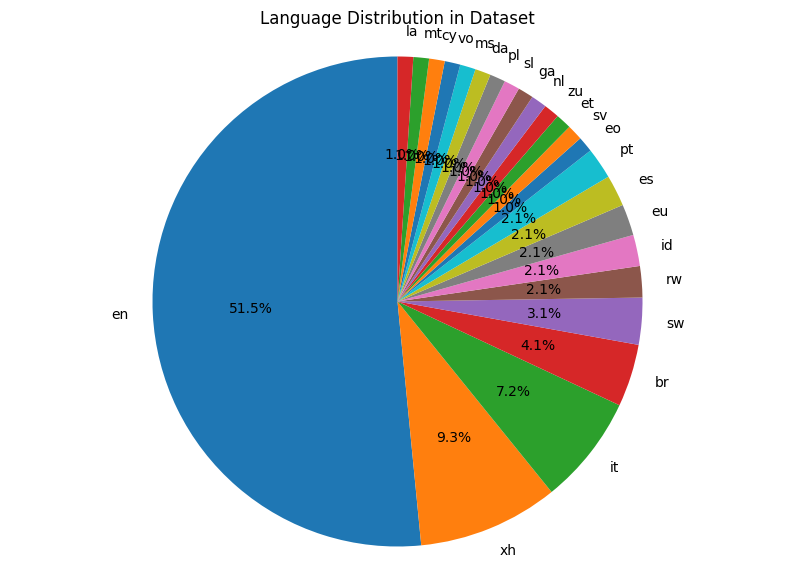

In [9]:
import matplotlib.pyplot as plt

languages = ['en', 'xh', 'it', 'br', 'sw', 'rw', 'id', 'eu', 'es', 'pt', 'eo', 'sv', 'et', 'zu', 'nl', 'ga', 'sl', 'pl', 'da', 'ms', 'vo', 'cy', 'mt', 'la']
percentages = [51.546392, 9.278351, 7.216495, 4.123711, 3.092784, 2.061856, 2.061856, 2.061856, 2.061856, 2.061856, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928, 1.030928]

plt.figure(figsize=(10, 7))
plt.pie(percentages, labels=languages, autopct='%1.1f%%', startangle=90)
plt.title("Language Distribution in Dataset")
plt.axis('equal')
plt.show()


       word_count  transcript_length
count   97.000000          97.000000
mean     9.597938          45.463918
std      5.055236          23.005462
min      2.000000          11.000000
25%      7.000000          32.000000
50%      8.000000          42.000000
75%     12.000000          51.000000
max     31.000000         153.000000


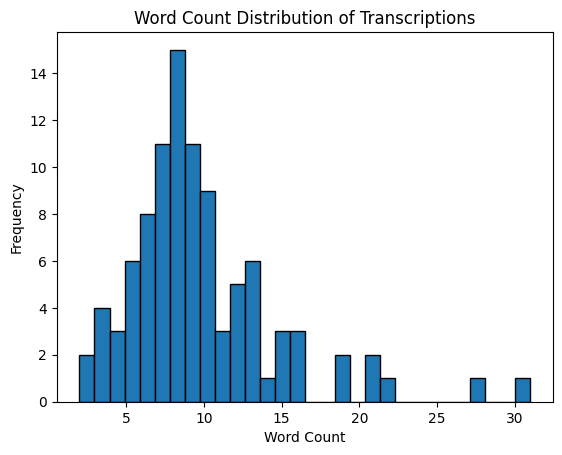

In [10]:
df['word_count'] = df['transcript'].apply(lambda x: len(x.split()))
df['transcript_length'] = df['transcript'].apply(lambda x: len(x))

print(df[['word_count', 'transcript_length']].describe())

import matplotlib.pyplot as plt
plt.hist(df['word_count'], bins=30, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution of Transcriptions')
plt.show()


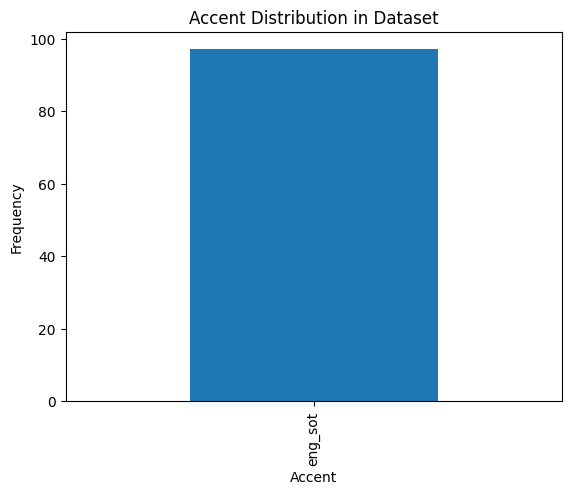

In [11]:
language_counts = df['accent'].value_counts()
language_counts.plot(kind='bar')
plt.xlabel('Accent')
plt.ylabel('Frequency')
plt.title('Accent Distribution in Dataset')
plt.show()

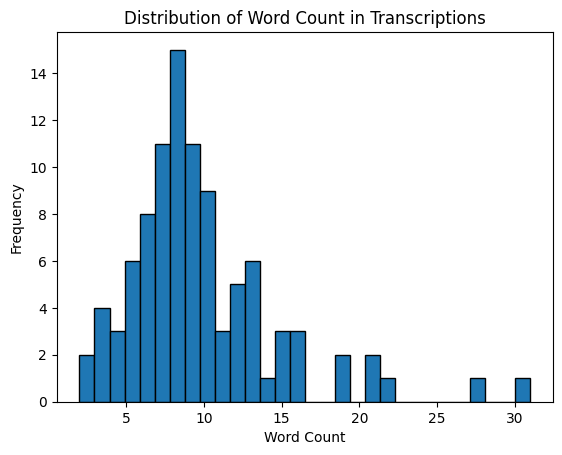

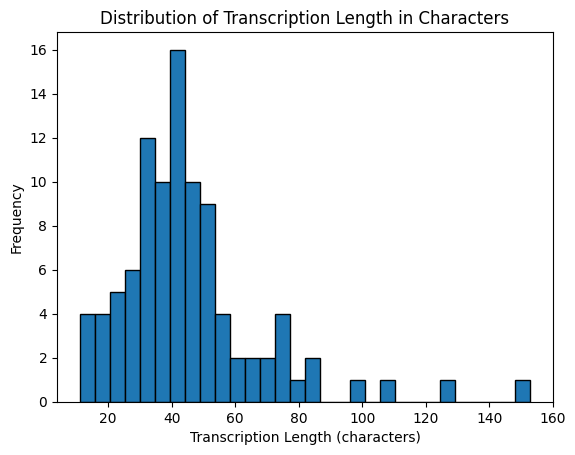

In [21]:
df['word_count'] = df['transcript'].apply(lambda x: len(x.split()))
df['transcription_length'] = df['transcript'].apply(lambda x: len(x))
plt.hist(df['word_count'], bins=30, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in Transcriptions')
plt.show()

plt.hist(df['transcription_length'], bins=30, edgecolor='black')
plt.xlabel('Transcription Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Transcription Length in Characters')
plt.show()


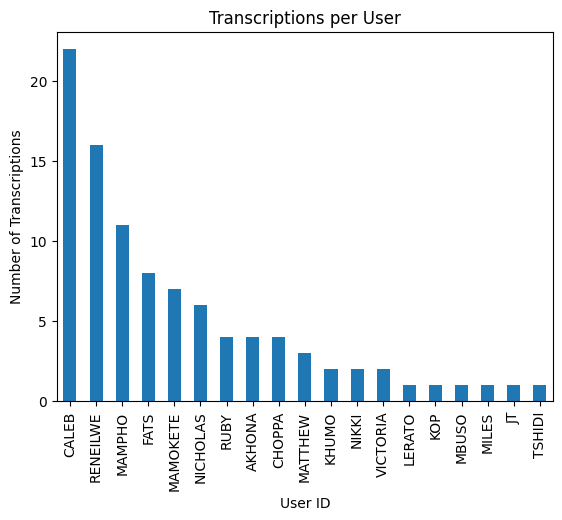

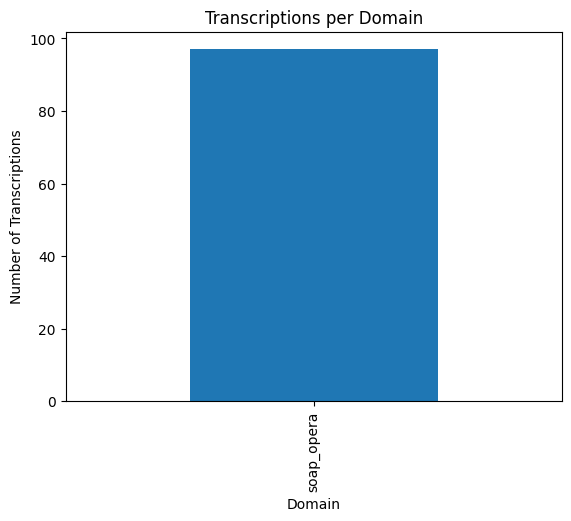

In [22]:
user_transcriptions = df['user_ids'].value_counts()
domain_transcriptions = df['domain'].value_counts()
user_transcriptions.plot(kind='bar', title='Transcriptions per User')
plt.xlabel('User ID')
plt.ylabel('Number of Transcriptions')
plt.show()

domain_transcriptions.plot(kind='bar', title='Transcriptions per Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Transcriptions')
plt.show()


In [ ]:
gender_transcriptions = df['gender'].value_counts()
gender_transcriptions.plot(kind='bar', title='Transcriptions per Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Transcriptions')
plt.show()

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

print(f"Found {len(audio_files)} .wav audio files.")

for audio in audio_files[:10]:
    audio_path = os.path.join(audio_folder, audio)
    y, sr = librosa.load(audio_path, sr=None)
    print(f"Audio: {audio}, Sample Rate: {sr}, Channels: {'Mono' if len(y.shape) == 1 else 'Stereo'}")

In [ ]:
durations = []
for audio in audio_files:
    if audio.endswith('.wav'):
        audio_path = os.path.join(audio_folder, audio)
        y, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
plt.figure(figsize=(12, 6))
sns.histplot(durations, kde=True, bins=30)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print("Audio Duration Statistics:")
print(f"Mean: {np.mean(durations)} seconds")
print(f"Max: {np.max(durations)} seconds")
print(f"Min: {np.min(durations)} seconds")

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'
audio_files = os.listdir(audio_folder)
print(f"Found {len(audio_files)} audio files.")
audio_files = [f for f in audio_files if not f.endswith('.csv')]

for audio in audio_files[:100]:
    if audio.endswith('.wav'):
        audio_path = os.path.join(audio_folder, audio)
        y, sr = librosa.load(audio_path, sr=None)
        print(f"Audio: {audio}, Sample Rate: {sr}, Channels: {'Mono' if len(y.shape) == 1 else 'Stereo'}")

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
for audio in audio_files:
    audio_sample_path = os.path.join(audio_folder, audio)

    y, sr = librosa.load(audio_sample_path, sr=None)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {audio}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

for audio in audio_files:
    audio_sample_path = os.path.join(audio_folder, audio)

    y, sr = librosa.load(audio_sample_path, sr=None)

    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {audio}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    plt.figure(figsize=(12, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f"Spectrogram of {audio}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

audio_sample_path = os.path.join(audio_folder, audio_files[0])

y, sr = librosa.load(audio_sample_path, sr=None)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(np.linspace(0, len(y) / sr, num=len(y)), y, color='b')
ax[0].set_title(f"Waveform of {audio_files[0]}")
ax[0].set_ylabel("Amplitude")
ax[0].grid(True)

img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title(f"Spectrogram of {audio_files[0]}")
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time (s)")

cbar = plt.colorbar(img, ax=ax[1], format='%+2.0f dB')
cbar.set_label("dB")

plt.tight_layout()
plt.show()


In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

audio_sample_path = os.path.join(audio_folder, audio_files[0])

y, sr = librosa.load(audio_sample_path, sr=None)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(np.linspace(0, len(y) / sr, num=len(y)), y, color='b')
ax[0].set_title(f"Waveform of {audio_files[0]}")
ax[0].set_ylabel("Amplitude")
ax[0].grid(True)

img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title(f"Spectrogram of {audio_files[0]}")
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time (s)")

cbar = plt.colorbar(img, ax=ax[1], format='%+2.0f dB')
cbar.set_label("dB")

plt.tight_layout()
plt.show()

In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

for audio in audio_files:
    audio_path = os.path.join(audio_folder, audio)
    y, sr = librosa.load(audio_path, sr=None)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='coolwarm')

    plt.colorbar(label='MFCC Coefficients')
    plt.title(f"MFCC of {audio}")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    plt.show()


In [ ]:
audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

silence_threshold = -40
min_silence_duration = 0.3

for audio in audio_files:
    audio_path = os.path.join(audio_folder, audio)

    y, sr = librosa.load(audio_path, sr=None)

    frame_length = int(sr * 0.02)
    hop_length = int(sr * 0.01)
    energy = np.array([
        sum(abs(y[i:i+frame_length]**2)) for i in range(0, len(y), hop_length)
    ])

    energy_db = librosa.power_to_db(energy, ref=np.max)

    silence_mask = energy_db < silence_threshold
    silent_times = np.where(silence_mask)[0] * hop_length / sr
    silent_segments = []
    start = None
    for i in range(len(silent_times) - 1):
        if start is None:
            start = silent_times[i]
        if silent_times[i+1] - silent_times[i] > min_silence_duration:
            if start is not None:
                silent_segments.append((start, silent_times[i]))
                start = None
    if start is not None:
        silent_segments.append((start, silent_times[-1]))
    plt.figure(figsize=(12, 6))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)

    for start, end in silent_segments:
        plt.axvspan(start, end, color='red', alpha=0.3, label="Silence")

    plt.title(f"Silence & Pause Detection in {audio}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
    print(f"\nDetected Silence in {audio}:")
    for start, end in silent_segments:
        print(f" - Silence from {start:.2f}s to {end:.2f}s (Duration: {end-start:.2f}s)")


In [ ]:
audio_path = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/AKHONA_12-11-02_237.wav'
y, sr = librosa.load(audio_path)

In [ ]:
Audio(audio_path)

In [ ]:
byte_io = io.BytesIO()
sf.write(byte_io, y, sr, format='wav')
audio_data = byte_io.getvalue()
audio_widget = widgets.Audio(value=audio_data, rate=sr)
display(audio_widget)

In [ ]:
csv_file_path = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions.csv'
df = pd.read_csv(csv_file_path)
df = df.rename(columns={'audio_ids': 'Filename', 'transcript': 'Transcription'})
df = df[['Filename', 'Transcription']]
output_csv_path = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptionscleaned.csv'
df.to_csv(output_csv_path, index=False)

print(f"Cleaned dataset saved to {output_csv_path}")

Now lets train the Whisper small and WavVec2 models on this audio datasets and transcribe

In [ ]:
!pip install openai-whisper
!pip install transformers torchaudio

But I have to reconsider installation of the !pip install transformers torchaudio:becasue whisper is enough for transcription. we need transormers and torchaudio when we need the task to include translation

In [ ]:
!pip install jiwer

The command !pip install jiwer installs the JIWER package, which is a Python library used for measuring word error rates (WER) in automatic speech recognition (ASR) systems. It provides utilities to compare transcriptions with the ground truth and calculate error metrics such as:

Word Error Rate (WER)
Character Error Rate (CER)
Sentence Error Rate (SER)
JIWER is commonly used to evaluate the performance of transcription models, including speech-to-text systems.

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install -U openai-whisper

!pip install git+https://github.com/openai/whisper.git:

This command installs whisper directly from the OpenAI GitHub repository. It ensures that you're getting the latest version of the Whisper library, even if it's not yet released on PyPI. This is useful if you want the most recent changes or features that may not yet be available in the official release.
!pip install -U openai-whisper:

This command installs or updates the openai-whisper package from PyPI (Python Package Index). The -U flag ensures that if you already have an older version of openai-whisper, it will be upgraded to the latest stable version.
Summary:
The first command installs the most recent version from GitHub, while the second ensures you have the latest stable release from PyPI.
If you're not specifically looking for the absolute latest changes from GitHub, the second command (!pip install -U openai-whisper) should be sufficient to get the latest stable release.

In [ ]:
import whisper

whisper_model = whisper.load_model("small")
def transcribe_audio_whisper(audio_file_path):
    result = whisper_model.transcribe(audio_file_path)
    return result['text']

audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

output_csv_file = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions_whisper.csv'

csv_data = []

for filename in os.listdir(audio_folder):
    if filename.endswith(".wav"):
        audio_file_path = os.path.join(audio_folder, filename)
        transcription = transcribe_audio_whisper(audio_file_path)
        csv_data.append([filename, transcription])

with open(output_csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Transcription"])
    writer.writerows(csv_data)

print(f"Transcriptions saved to {output_csv_file}")


In [ ]:
wav2vec_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

def transcribe_audio_wav2vec(audio_file_path):
    audio_input, _ = librosa.load(audio_file_path, sr=16000)

    input_values = wav2vec_processor(audio_input, return_tensors="pt").input_values

    with torch.no_grad():
        logits = wav2vec_model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = wav2vec_processor.decode(predicted_ids[0])

    return transcription

audio_folder = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2'

output_csv_file = '/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/wav2vec_transcriptions.csv'

csv_data = []

for filename in os.listdir(audio_folder):
    if filename.endswith(".wav"):
        audio_file_path = os.path.join(audio_folder, filename)

        transcription = transcribe_audio_wav2vec(audio_file_path)

        csv_data.append([filename, transcription])

with open(output_csv_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Filename", "Transcription"])
    writer.writerows(csv_data)

print(f"Transcriptions saved to {output_csv_file}")


now lets do the Report the Character Error Rate CER, Word Error Rate WER, and any other
relevant performance metrics for each of the models with our groundtruth model

In [ ]:
!pip install jiwer
!pip install editdistance


In [ ]:
import editdistance

In [ ]:
ground_truth_wav2vec2 = "ja ebile ba re maybe ba tlo mo. demote. -a. as head boy."
asr_output_wav2vec2 = "ye ivelabo me macomtimote as his boy"

error_measures_wav2vec2 = compute_measures(ground_truth_wav2vec2, asr_output_wav2vec2)

print(f"Word Error Rate (WER) for Wav2Vec2: {error_measures_wav2vec2['wer']:.2%}")
print(f"Substitutions: {error_measures_wav2vec2['substitutions']}")
print(f"Insertions: {error_measures_wav2vec2['insertions']}")
print(f"Deletions: {error_measures_wav2vec2['deletions']}")


In [ ]:

ground_truth = 'ja ebile ba re maybe ba tlo mo. demote. -a. as head boy.'
predicted_wav2vec2 = 'ye ivelabo me macomtimote as his boy'

cer = editdistance.eval(ground_truth, predicted) / len(ground_truth)
print(f"CER: {cer}")


In [ ]:
ground_truth = 'ja ebile ba re maybe ba tlo mo. demote. -a. as head boy.'
predicted_whisper_small = 'Yeah, I believe I am the one who is the most stupid boy.'

cer = editdistance.eval(ground_truth, predicted) / len(ground_truth)
print(f"CER: {cer}")

In [ ]:
def word_error_rate(ground_truth, predicted):
    ground_truth_words = ground_truth.split()
    predicted_words = predicted.split()


    wer = editdistance.eval(ground_truth_words, predicted_words) / len(ground_truth_words)
    return wer


ground_truth = 'ja ebile ba re maybe ba tlo mo. demote. -a. as head boy.'
predicted_whisper_small = 'Yeah, I believe I am the one who is the most stupid boy.'

wer = word_error_rate(ground_truth, predicted_whisper_small)
print(f"WER: {wer:.2%}")


In [ ]:
ground_truth_df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptionscleaned.csv')
generated_df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/wav2vec_transcriptions.csv')

ground_truth_df.columns = ['Filename', 'Transcription']
generated_df.columns = ['Filename', 'Transcription']

def character_error_rate(ground_truth, predicted):
    cer = editdistance.eval(ground_truth, predicted) / len(ground_truth)
    return cer

def word_error_rate(ground_truth, predicted):
    ground_truth_words = ground_truth.split()
    predicted_words = predicted.split()
    wer = editdistance.eval(ground_truth_words, predicted_words) / len(ground_truth_words)
    return wer

results = []

for idx, row in ground_truth_df.iterrows():
    filename = row['Filename']

    generated_row = generated_df[generated_df['Filename'] == filename]

    if not generated_row.empty:
        generated_transcription = generated_row['Transcription'].values[0]
        ground_truth_transcription = row['Transcription']

        cer = character_error_rate(ground_truth_transcription, generated_transcription)
        wer = word_error_rate(ground_truth_transcription, generated_transcription)


        results.append({
            'Filename': filename,
            'CER': cer,
            'WER': wer
        })

results_df = pd.DataFrame(results)

print(results_df)
results_df.to_csv('comparison_results.csv', index=False)


In [ ]:
average_cer = results_df['CER'].mean()
average_wer = results_df['WER'].mean()

print(f"Average CER: {average_cer:.4f}")
print(f"Average WER: {average_wer:.4f}")

In [ ]:
ground_truth_df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptionscleaned.csv')
generated_df = pd.read_csv('/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions_whisper.csv')

ground_truth_df.columns = ['Filename', 'Transcription']
generated_df.columns = ['Filename', 'Transcription']

def character_error_rate(ground_truth, predicted):
    cer = editdistance.eval(ground_truth, predicted) / len(ground_truth)
    return cer

def word_error_rate(ground_truth, predicted):
    ground_truth_words = ground_truth.split()
    predicted_words = predicted.split()
    wer = editdistance.eval(ground_truth_words, predicted_words) / len(ground_truth_words)
    return wer

results = []

for idx, row in ground_truth_df.iterrows():
    filename = row['Filename']

    generated_row = generated_df[generated_df['Filename'] == filename]

    if not generated_row.empty:
        generated_transcription = generated_row['Transcription'].values[0]
        ground_truth_transcription = row['Transcription']

        cer = character_error_rate(ground_truth_transcription, generated_transcription)
        wer = word_error_rate(ground_truth_transcription, generated_transcription)

        results.append({
            'Filename': filename,
            'CER': cer,
            'WER': wer
        })

results_df = pd.DataFrame(results)

print(results_df)
results_df.to_csv('comparison_results.csv', index=False)


In [ ]:
average_cer = results_df['CER'].mean()
average_wer = results_df['WER'].mean()

print(f"Average CER: {average_cer:.4f}")
print(f"Average WER: {average_wer:.4f}")


We did more error analyisis, lkie insertion, substitution and deletion on Whisper small model. We have also visualized distribution of word error rate accross the datset and word error rate box plot. The number of each

In [ ]:
from jiwer import wer, compute_measures

ground_truth_whisper = "ja ebile ba re maybe ba tlo mo. demote. -a. as head boy."
asr_output_whisper = "Yeah, I believe I'm the one who's the most stupid boy."

error_measures_whisper = compute_measures(ground_truth_whisper, asr_output_whisper)

print(f"Word Error Rate (WER) for Whisper Small: {error_measures_whisper['wer']:.2%}")
print(f"Substitutions: {error_measures_whisper['substitutions']}")
print(f"Insertions: {error_measures_whisper['insertions']}")
print(f"Deletions: {error_measures_whisper['deletions']}")

In [ ]:
ground_truth_wav2vec2 = "ja ebile ba re maybe ba tlo mo. demote. -a. as head boy."
asr_output_wav2vec2 = "ye ivelabo me macomtimote as his boy"

error_measures_wav2vec2 = compute_measures(ground_truth_wav2vec2, asr_output_wav2vec2)

print(f"Word Error Rate (WER) for Wav2Vec2: {error_measures_wav2vec2['wer']:.2%}")
print(f"Substitutions: {error_measures_wav2vec2['substitutions']}")
print(f"Insertions: {error_measures_wav2vec2['insertions']}")
print(f"Deletions: {error_measures_wav2vec2['deletions']}")


In [ ]:
ground_truth_df = pd.read_csv("/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptionscleaned.csv")
whisper_output_df = pd.read_csv("/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions_whisper.csv")

assert len(ground_truth_df) == len(whisper_output_df), "Mismatch in dataset lengths!"

results = []

for i in range(len(ground_truth_df)):

    ground_truth_text = ground_truth_df.loc[i, "Transcription"]
    asr_output_text = whisper_output_df.loc[i, "Transcription"]


    error_measures = compute_measures(ground_truth_text, asr_output_text)

    results.append({
        "Index": i,
        "WER": error_measures["wer"],
        "Substitutions": error_measures["substitutions"],
        "Insertions": error_measures["insertions"],
        "Deletions": error_measures["deletions"]
    })

results_df = pd.DataFrame(results)

results_df.to_csv("whisper_evaluation_results.csv", index=False)

plt.figure(figsize=(10, 5))
sns.histplot(results_df["WER"], bins=20, kde=True)
plt.xlabel("Word Error Rate (WER)")
plt.ylabel("Frequency")
plt.title("Distribution of Word Error Rate (WER)")
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(y=results_df["WER"])
plt.ylabel("Word Error Rate (WER)")
plt.title("WER Box Plot")
plt.grid()
plt.show()

print(results_df.head())

finally explainable techniques LIME and SHAP were used and alayzed here

In [ ]:

ground_truth_df = pd.read_csv("/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptionscleaned.csv")
whisper_output_df = pd.read_csv("/content/lelapa_extracted/dataset_v2/dataset_v2cleaned/dataset_v2/transcriptions_whisper.csv")
assert len(ground_truth_df) == len(whisper_output_df), "Mismatch in dataset lengths!"

results = []
for i in range(len(ground_truth_df)):

    ground_truth_text = ground_truth_df.loc[i, "Transcription"]
    asr_output_text = whisper_output_df.loc[i, "Transcription"]

    error_measures = compute_measures(ground_truth_text, asr_output_text)

    results.append({
        "Index": i,
        "Ground Truth": ground_truth_text,
        "Whisper Output": asr_output_text,
        "WER": error_measures["wer"]
    })

results_df = pd.DataFrame(results)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(results_df["Whisper Output"])
y = results_df["WER"].values

model = Ridge()
model.fit(X, y)

# SHAP Explanation
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, feature_names=vectorizer.get_feature_names_out())

# LIME Explanation
lime_explainer = lime.lime_text.LimeTextExplainer(class_names=["Low WER", "High WER"])
idx = 0  in

def predict_fn(texts):
    text_features = vectorizer.transform(texts)

    preds = model.predict(text_features)
    return np.column_stack([(preds < np.median(preds)).astype(int), (preds >= np.median(preds)).astype(int)])
lime_exp = lime_explainer.explain_instance(results_df.loc[idx, "Whisper Output"], predict_fn, num_features=10)
lime_exp.show_in_notebook()
results_df.to_csv("whisper_evaluation_with_explanations.csv", index=False)

print(results_df.head())